In [1]:
import dva_sdhdf_combine_v3
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from astropy.modeling import models, fitting

In [2]:
#day ='41'
#surveyphase = '2'

#### Change the directory to where the files are located" ####
#dir_in = '/home2/DATA_AO/DVA_DATA/survey_phase2_day'+day+'/'
#dir_out = '/home2/DATA_AO/DVA_DATA/dva_phase2/survey_phase2_day'+day+'/'
#dir_in = '/home2/DATA_AO/DVA_DATA/drone_CHIME/'
#dir_out = '/home2/DATA_AO/DVA_DATA/drone_CHIME/'
#dir_in = '/home/ordoga/Mar29_spect_test/test_Mar29/'
#dir_out = '/home/ordoga/Mar29_spect_test/test_Mar29/'
#dir_in = '/home2/DATA_AO/DVA_DATA/el_scans_Apr2023/'
#dir_out = '/media/ordoga/15m_band1_survey/el_scans_Apr2023/'
dir_in = '/home/ordoga/DVA_June2023/'
dir_out = '/home/ordoga/DVA_June2023/'
##############################################################

In [4]:
imp.reload(dva_sdhdf_combine_v3)

#start = '2022-10-26T23:30:00.0'
#stop = '2022-10-27T01:20:00.0'
#outname = 'drone_CHIME'

start = '2023-06-28T18:50:00.0'
stop = '2023-06-28T19:35:00.0'
outname = 'day2_tests'

dva_sdhdf_combine_v3.combine(dir_in,dir_out,start,stop,outname,freq_s=2,
                                 az_scan_trim=False,freq_avg=True)


Number of files:  96

------------------------------------------------------------------------
Number of frequency slices or bins (CAUTION: SHOULD BE WHOLE NUMBER):  1650.0
------------------------------------------------------------------------
8250
Timestamps per file:  50
1 /home/ordoga/DVA_June2023/2023-06-28T18:49:06.000000Z.h5
2 /home/ordoga/DVA_June2023/2023-06-28T18:49:36.000000Z.h5
3 /home/ordoga/DVA_June2023/2023-06-28T18:50:06.000000Z.h5
4 /home/ordoga/DVA_June2023/2023-06-28T18:50:36.000000Z.h5
5 /home/ordoga/DVA_June2023/2023-06-28T18:51:06.000000Z.h5
6 /home/ordoga/DVA_June2023/2023-06-28T18:51:36.000000Z.h5
7 /home/ordoga/DVA_June2023/2023-06-28T18:52:06.000000Z.h5
8 /home/ordoga/DVA_June2023/2023-06-28T18:52:36.000000Z.h5
9 /home/ordoga/DVA_June2023/2023-06-28T18:53:06.000000Z.h5
10 /home/ordoga/DVA_June2023/2023-06-28T18:53:36.000000Z.h5
11 /home/ordoga/DVA_June2023/2023-06-28T18:54:06.000000Z.h5
12 /home/ordoga/DVA_June2023/2023-06-28T18:54:36.000000Z.h5
13 /home/ord

## Read in data

In [5]:
%%time

#outname = 'Day41_fail'
#outname = 'drone_CHIME'
outname = 'day2_tests'
file = h5py.File(dir_out+outname+'.h5','r')
print(file)
    
dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
# Add the position and time data to the corresponding arrays:
dec_set = dataset['metadata']['declination']
ra_set = dataset['metadata']['right_ascension']
el_set = dataset['metadata']['elevation']
az_set = dataset['metadata']['azimuth']
t_set = dataset['metadata']['utc']
noise_set = dataset['metadata']['noise_state']
freq = file['data']['beam_0']['band_SB0']['frequency'][:]/1e6
RR_set = dataset['data'][:,0,:]
LL_set = dataset['data'][:,1,:]
reRL_set = dataset['data'][:,2,:]
imRL_set = dataset['data'][:,3,:]
    
t_set_plt = Time(t_set, format='isot',scale='utc').mjd

<HDF5 file "day2_tests.h5" (mode r)>
CPU times: user 58.8 ms, sys: 769 ms, total: 827 ms
Wall time: 822 ms


## Generic waterfall plot

In [6]:
print(RR_set.shape)

(4800, 8250)


Text(0, 0.5, 'Frequency (MHz)')

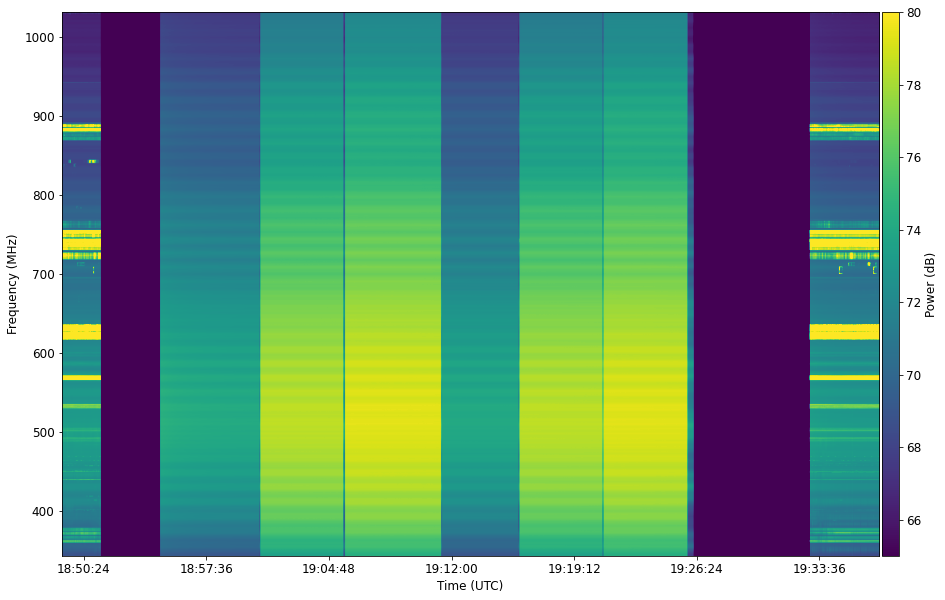

In [7]:
fig,axs = plt.subplots(1,1,figsize=(15,10)) 
    
fs = 12
    
extent = [t_set_plt[0],t_set_plt[-1],freq[0],freq[-1]]
    
im = axs.imshow(10*np.log10(RR_set.T),aspect='auto',vmin=65,vmax=80,
                origin='lower',extent=extent,cmap='viridis')

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)

axs.set_xlim(extent[0],extent[1])
axs.set_ylim(freq[0],freq[-1])
axs.tick_params(axis='both', labelsize=fs)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.set_xlabel('Time (UTC)',fontsize=fs)        
axs.set_ylabel('Frequency (MHz)',fontsize=fs)

#plt.tight_layout()
#plt.savefig('../DVA2/PLOTS/dva_drone_noise_waterfall.pdf')

802.1041666666667
(4800,)
(4800,)
[60123.78409722 60123.78410417 60123.78411111 ... 60123.81740972
 60123.81741667 60123.81742361]


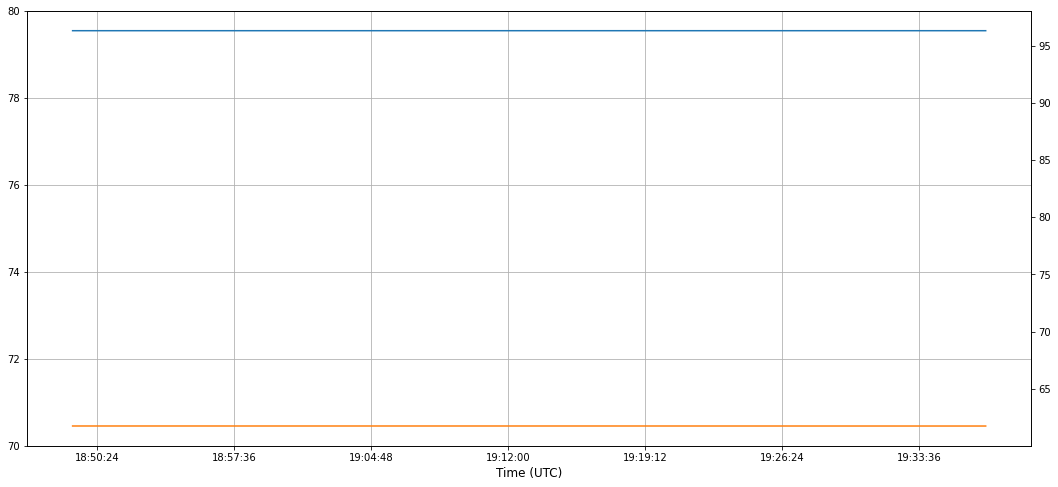

In [8]:
fig1, axs = plt.subplots(1,1,figsize=(18,8))

i1 = 0
i2 = 8000
fr_idx = 5500
print(freq[fr_idx])
print(LL_set[:,fr_idx].shape)
print(t_set_plt.shape)
print(t_set_plt)

axs.plot(t_set_plt[i1:i2],10*np.log10(LL_set[i1:i2,fr_idx]),color='black')
ax2 = axs.twinx()
ax2.plot(t_set_plt[i1:i2],az_set[i1:i2])
ax2.plot(t_set_plt[i1:i2],el_set[i1:i2])
#axs.legend(fontsize=14)

axs.tick_params(axis="x")
axs.tick_params(axis="y")
#axs.set_xlim(350,1030)
axs.set_ylim(70,80)
#axs.set_xlabel('Frequency (MHz)',fontsize=14)
#axs.set_ylabel('Power (dB)',fontsize=14)
#axs.set_title('Survey phase '+surveyphase+' day '+day,fontsize=14)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.set_xlabel('Time (UTC)',fontsize=fs)  
axs.grid()

In [ ]:
fig1, axs = plt.subplots(1,1,figsize=(18,6))

ii1 = 1600
ii2 = 2850

print(t_set[ii1])
print(t_set[ii2])

axs.plot(freq,10*np.log10(LL_set[ii1,:]),label='with drone')
axs.plot(freq,10*np.log10(LL_set[ii2,:]),label='no drone')
axs.legend(fontsize=14)

axs.tick_params(axis="x")
axs.tick_params(axis="y")
axs.set_xlim(350,1030)
axs.set_ylim(65,95)
axs.set_xlabel('Frequency (MHz)',fontsize=14)
axs.set_ylabel('Power (dB)',fontsize=14)
#axs.set_title('Survey phase '+surveyphase+' day '+day,fontsize=14)
axs.grid()

#plt.tight_layout()
#plt.savefig('../DVA2/PLOTS/dva_drone_noise_spectrum.pdf')

In [ ]:
10**(-0.25/10)

In [ ]:
fig1, axs = plt.subplots(1,1,figsize=(18,6))

axs.scatter(t_set_plt,az_set,s=1)

axs.tick_params(axis="x")
axs.tick_params(axis="y")
axs.set_xlim(t_set_plt[0]+0.08,t_set_plt[-1]+0.01)
axs.set_ylim(-10,370)
axs.set_xlabel('Time (UTC)',fontsize=14)
#axs.set_ylabel('RA (hr)',fontsize=14)
axs.set_title('Survey phase '+surveyphase+' day '+day,fontsize=14)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.grid()

In [ ]:
print(az_set[-1])
print(t_set[-1])

In [ ]:
(283.77-67)*18/360

In [ ]:
imp.reload(dva_sdhdf_combine_v3)

start = '2022-09-26T00:00:00.0'
stop = '2022-09-26T23:59:59.0'

#start = '2022-09-24T00:31:58.0'
#stop = '2022-09-26T14:33:58.0'
outname = 'NCP_Fall_2022_part3'
dirfiles = '/home2/DATA_AO/DVA_DATA/NCP_Sept2022/'

dva_sdhdf_combine_v3.combine(dirfiles,dirfiles,start,stop,outname,freq_s=12,
                                 az_scan_trim=False,freq_avg=True)

In [ ]:
%%time
dirfiles = '/home2/DATA_AO/DVA_DATA/NCP_Sept2022/'
outname = 'NCP_Fall_2022_part3'
file = h5py.File(dirfiles+outname+'.h5','r')
print(file['data']['beam_0'].keys())
    
dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
# Add the position and time data to the corresponding arrays:
dec_set = dataset['metadata']['declination']
ra_set = dataset['metadata']['right_ascension']
el_set = dataset['metadata']['elevation']
az_set = dataset['metadata']['azimuth']
t_set = dataset['metadata']['utc']
noise_set = dataset['metadata']['noise_state']
freq = file['data']['beam_0']['band_SB0']['frequency'][::12]/1e6

t_set_plt = Time(t_set, format='isot',scale='utc').mjd

In [ ]:
fig1, axs = plt.subplots(1,1,figsize=(18,6))

axs.scatter(t_set_plt,az_set,s=1)

axs.tick_params(axis="x")
axs.tick_params(axis="y")
#axs.set_xlim(t_set_plt[0]+0.08,t_set_plt[-1]+0.01)
axs.set_ylim(-10,370)
axs.set_xlabel('Time (UTC)',fontsize=14)
#axs.set_ylabel('RA (hr)',fontsize=14)
#axs.set_title('Survey phase '+surveyphase+' day '+day,fontsize=14)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.grid()